In [1]:
#!pip install --upgrade pip
#!pip install pandas --user
#!pip install numpy --user
#!pip install matplotlib --user
#!pip install seaborn --user
#!pip install scikit0-learn --user
#!pip install scikit-learn --user
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import sklearn
import seaborn as sb
import random

# Scratch Implementation #

### Reading the data ###

In [2]:
df = pd.read_csv('data.csv', delimiter = ',')
df = df.reindex(np.random.permutation(df.index))

### Checking the data out ###

In [3]:
#df.info()
df.describe()
#df

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [4]:
#It seems i'll have to drop columns : Unnamed 32 and id as they do not add any value to clustering 
#since they are either null or unique values

In [5]:
df = df.drop(columns='id')
df = df.drop(columns='Unnamed: 32')
#print(df.diagnosis)
classAnswerData = df['diagnosis'].map({'M':1,'B':0})

### Correlation matrix ###

<AxesSubplot: >

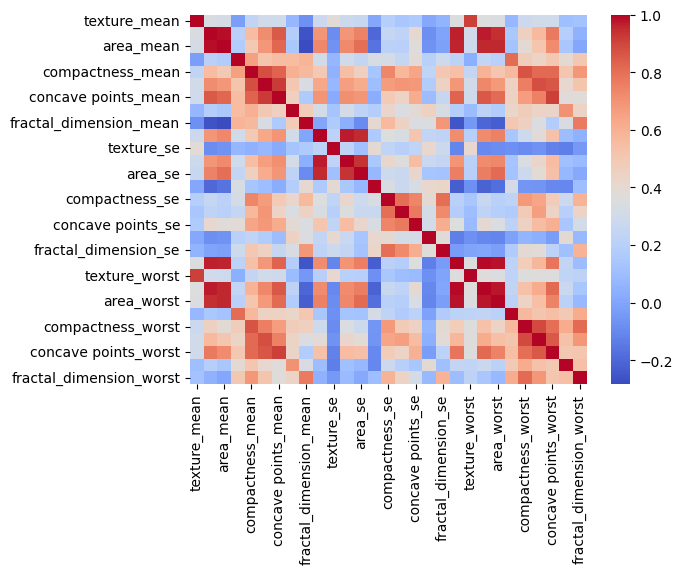

In [6]:
features = df.iloc[:, 2:]

# Compute the correlation matrix
corr_matrix = features.corr()

# Visualize the correlation matrix using a heatmap
sb.heatmap(corr_matrix, cmap='coolwarm')

In [7]:
#I'm gonna use the features which are lowly correlated to most other features. The list of features used are:
#['texture_mean', 'radius_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean',
    #'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
    
#Surprisingly they turn out to be in my opinion the mean attributes.

## Spectral Clustering Implementation ##

### Step 1 : Making the Similarity Graph ###

In [8]:
#i am using the gaussian kernel method for calculating the similarity graph. This method takes the distance, multiplies it
# with gamma and puts them as negative power to e(e = 2.715 approximately). This is helpful as the points which have higher
# distance between them will be having a low value in the matrix showing that they are less similar than the points which have
# lesser distance between them(and hence have a higher value in the matrix for them). 
def computeSimilarityGraph(X):
    gamma = 1 / (2 * np.var(X))
    SimilarityGraph = np.exp(-gamma * cdist(X, X, 'sqeuclidean'))
    return SimilarityGraph
#SimilarityGraph = computeSimilarityGraph(X)
#print(SimilarityGraph)

### Step 2 : Making the Laplacian Matrix ###

In [9]:
#Now I am gonna calculate the Laplacian matrix. I could have used similarity graph but it does not capture connectivity pattern
# of the dataset. In the next steps i am going to calculate normalized eigenvectors hence i am not gonna normalize the 
# laplacian here., otherwise i would be increasing the computations of the computer.
def computeLaplacianMatrix(SimilarityGraph):
    DegreeMatrix = np.diag(np.sum(SimilarityGraph, axis=1))
    LaplacianMatrix = DegreeMatrix - SimilarityGraph
    return LaplacianMatrix
#LaplacianMatrix = computeLaplacianMatrix(SimilarityGraph)
#print(LaplacianMatrix)

### Step 3 : Computing Eigenvectors ###

In [10]:
#Now i am going to find out the first k normalized eigenvectors of the laplacian in order to cluster them using k-means
#in the future. Extraction of eigenvectors is important as they capture the dataset and represents it in a low-dimensional
#(in this case 2 dimensional) space. Also normalization reduces the chance of output getting affected by outliers as it maps the
# eigenvectors to a unit sphere, other than the fact that it makes computation for k-means very easy.
def computeEigenVectors(LaplacianMatrix, k):
    _, eigvecs = np.linalg.eigh(LaplacianMatrix)
    eigvecs = eigvecs[:, :k]
    
    # Normalize the rows of eigvecs
    norms = np.linalg.norm(eigvecs, axis=1)
    eigvecs = eigvecs / norms[:, np.newaxis]
    return eigvecs
#eigenvecs = computeEigenVectors(LaplacianMatrix, k = 2)
#print(eigenvecs)

### Step 4 : Clustering the Eignevectors ###

In [11]:
listOfIndicesForKEqual2 = [ [546, 49], [246, 74], [178, 477], [190, 294], [345, 36], ]
#What this list is meant for: 
# For k==2, i found that a certain list of values of indices provided optimal results for clustering. The best one being
# produced by indices==[546, 49]. So, whenever k==2, I have decided to chose a value from the above list. However, I think
# yoy guys might not like it, I've gone with the traditional method of making a completely random choice for indices of the initial
# centroid. You can remove the comment below(if k==2 and else part) to check the implementation if you want
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))
#The above function takes two points and calculates the euclidean distance between them.
def distance(XA, XB):
        n_XA = XA.shape[0]
        n_XB = XB.shape[0]
        dist = np.zeros((n_XA, n_XB))
        for i in range(n_XA):
            for j in range(n_XB):
                dist[i, j] = euclidean_distance(XA[i], XB[j])
        return dist
#the distance function calculates the distance between all points over the two input dataframes.
def kmeans(X, k, max_iter=1):
     #Initialize the centroids randomly
    #if k==2:
     #    indices = random.choice(listOfIndicesForKEqual2)
     #    indices = [546, 49]
    #else :
    indices = np.random.choice(X.shape[0], size=k, replace=False)
#The above two commands of if and else chose the random indices to begin the calculation of k-means. The initial centroids are 
#the same point X[indices]. 
    #print(indices)
    centroids = X[indices]

    for i in range(max_iter):
        # Assign the data points to the nearest centroid
        distances = distance(X, centroids)
        labels = np.argmin(distances, axis=1)
#distances are calcuated between points and the centroid. This gives a matrix of 569x2 dimensions.
#Then labels are assigned by comparing the distance put in the two columns of each row. The column number of the minimum distance
# cell is allotted as the label. This values is either 0 or 1 since there are two columns they would be numbered 0 and 1.
# This process happens 569 times for all the entries.
        # Update the centroids
        for j in range(k):
            centroids[j] = np.mean(X[labels == j], axis=0)
#These points are now getting updated by the loop for j in range(k). This happens for every iteration of k-means. In my 
#implementation there is only one iteration.
    return centroids, labels
#print(centroids)
#print(labels)

### The function  ###

In [12]:
#the following function uses all the above defined functions in sequence to give centroids and labels obtained after
#spectral clustering. The function returns centroids and labels of the clusters formed after spectral clustering.
def spectralClustering(X, k = 2):
    simGraph = computeSimilarityGraph(X)
    lapMat = computeLaplacianMatrix(simGraph)
    normalizedEigenVectors = computeEigenVectors(lapMat, 2)
    return kmeans(normalizedEigenVectors, 2)


## The subset of data I am using for clustering
X = df[['texture_mean', 'radius_mean', 'perimeter_mean','area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
        'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']].values
centroids, labels = spectralClustering(X, 2)

### Step 5 : Plotting the graph ###

Text(0.5, 1.0, 'Actual Clusters')

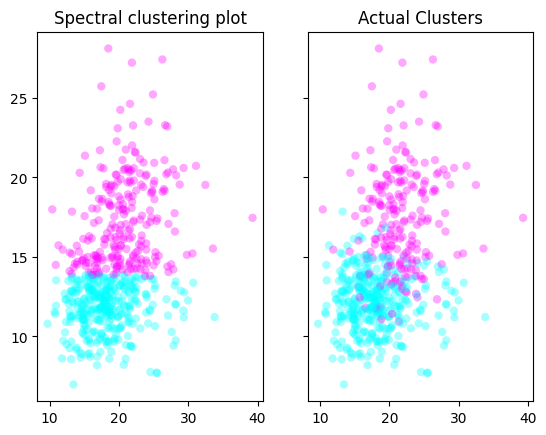

In [13]:
f, (spec, actual) = plt.subplots(1,2, sharey=True)

spec.scatter(X[:,0],X[:,1],  c=labels, cmap = "cool", edgecolor = "None", alpha=0.35)
spec.set_title('Spectral clustering plot')

actual.scatter(X[:,0], X[:,1],  c=classAnswerData, cmap = "cool", edgecolor = "None", alpha=0.35)
actual.set_title('Actual Clusters')

#Nothing much. Just plotting the clustered labels and actual labels of df.diagnosis saved in classAnswerData.

### Step 6 : Evaluation ###

In [14]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import silhouette_score

#### Split for 10-fold cross validation ####

In [15]:
n_splits = 10
Split = np.array_split(X, n_splits)
y_split = np.array_split(classAnswerData, n_splits)

#Now we implement spectralClustering on the 10 splits of data and store the predicted clusters in a list.
specPerformance = [spectralClustering(Split[i], 2) for i in range(0, 10)]

C:\Python311\Lib\site-packages\numpy\lib\shape_base.py:790: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


#### silhouette score ####

In [16]:
silhouette_scores=[silhouette_score(specPerformance[i][1].reshape(-1, 1), y_split[i].values.reshape(-1, 1)) for i in range(1, 10)]
print(silhouette_scores)

[0.5497213030880563, 0.8956140350877192, 0.42329367480002683, -0.2075187969924812, 0.3848490263116302, 0.49252761533463285, 0.003629764065335745, 0.45912446972332277, 0.2138278388278388]


C:\Users\EndUser\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\EndUser\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\EndUser\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\EndUser\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y 

#### nmi score ####

In [31]:
NMIScores = [normalized_mutual_info_score(labels_pred =specPerformance[i][1], labels_true = y_split[i].values) for i in range(1, 10)]
print(NMIScores)

[0.32886535957679786, 0.7943307261466005, 0.280860211127147, 0.05792531148035622, 0.31502256096419967, 0.43036096235919347, 0.07816829471493754, 0.28494339133132535, 0.2980718056594967]


#### Errorbars ####

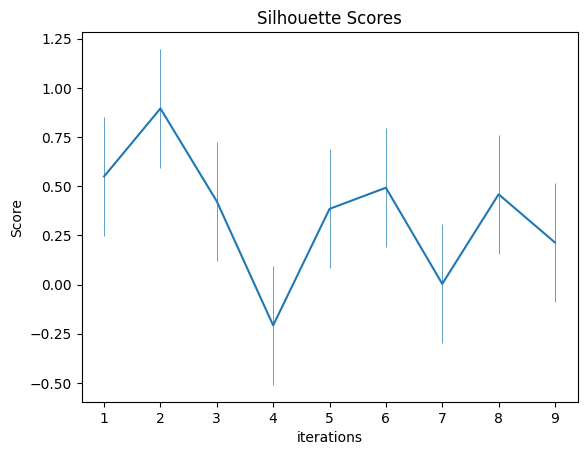

In [53]:
l = list(range(1, 10))

plt.errorbar(x = l, y = silhouette_scores, yerr = np.std(silhouette_scores) , elinewidth = 0.5)
plt.title('Silhouette Scores')
plt.ylabel('Score')
plt.xlabel('iterations')
plt.show()

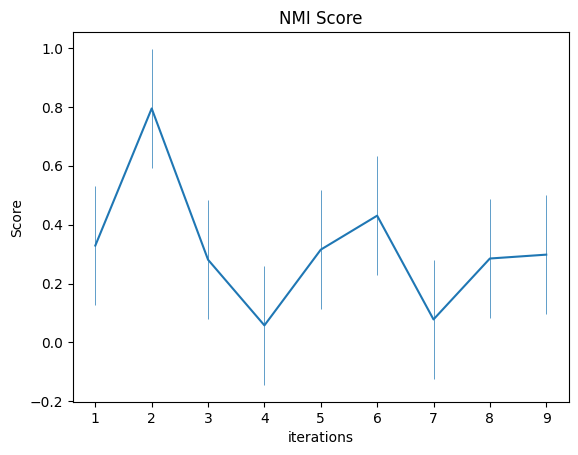

In [54]:
plt.errorbar(x = l, y = NMIScores, yerr = np.std(NMIScores), elinewidth = 0.5)
plt.title('NMI Score')
plt.xlabel('iterations')
plt.ylabel('Score')
plt.show()

In [117]:
np.mean(NMIScores)

0.3187276248177838

# Implementation Correctness #

#### Scanning the CSV ####

In [146]:
newdf = pd.read_csv('final.csv')
newdf = newdf.reindex(np.random.permutation(newdf.index))
#print(df)
# Extracting the features from the DataFrame
newX = newdf[['Feature 1', 'Feature 2']].values
newdf.describe()
newdf

,Feature 1,Feature 2,Class/Cluster
11,0.000,2.042871,1
12,0.000,3.150677,1
14,3.000,1.629463,2
5,5.245,0.000000,1
8,8.500,0.000000,1
16,3.000,2.923104,2
3,3.125,0.000000,1
4,4.180,0.000000,1
7,7.405,0.000000,1
15,3.000,2.268944,2


## Part 1 : Adjacency Matrix for Similarity Graph ##

In [147]:
class NearestNeighbors:
    def fit(self, X):
        self.X = X
        
    def knneighbors(self, X, n_neighbors):
        self.n_neighbors = n_neighbors
        distances = self._brute_distances(X)
        
        idx = np.argsort(distances, axis=1)
        idx = idx[:, :self.n_neighbors]
        distances = np.take_along_axis(distances, idx, axis=1)
        
        return distances, idx
        
    def _brute_distances(self, X):
        SimilarityMatrix = np.zeros((X.shape[0], self.X.shape[0]))
        for i, x in enumerate(X):
            SimilarityMatrix[i, :] = np.linalg.norm(self.X - x, axis=1)
        return SimilarityMatrix

nbrs = NearestNeighbors()
nbrs.fit(newX)
distances, indices = nbrs.knneighbors(newX, 2)

# Create empty adjacency matrix
n_samples = newX.shape[0]
newAdjacencyMatrix = np.zeros((n_samples, n_samples), dtype=int)

# Add edges between each data point and its 2 nearest neighbors
for i in range(n_samples):
    for j in indices[i, 1:]:  # exclude itself from neighbors
        newAdjacencyMatrix[i, j] = 1
        newAdjacencyMatrix[j, i] = 1

# Print the adjacency matrix
print(newAdjacencyMatrix)

[[0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]]


## Part 2 : Spectral Embeddings ##

#### Finding the normalized laplacian matrix ####

In [132]:
newDegreeMatrix = np.diag(np.sum(newAdjacencyMatrix, axis=1))
#print(DegreeMatrix)

In [133]:
newLaplacianMatrix = newDegreeMatrix - newAdjacencyMatrix
#print(Laplacian)

#### Normalizing Laplacian ####

In [134]:
DMSQRTINV = np.linalg.inv(np.sqrt(newDegreeMatrix))
#print(DMSQRTINV)

In [135]:
NormalizedLaplacian = DMSQRTINV@newLaplacianMatrix@DMSQRTINV
#print(NormalizedLaplacian)

#### Finding the embeddings by normalizing eigenvectors ####

In [136]:
_, eigenVectorsOfNormalizedLaplacian = np.linalg.eigh(NormalizedLaplacian)
eigenVectorsOfNormalizedLaplacian = eigenVectorsOfNormalizedLaplacian[:, :2]
#here i chose the first two normalized eigenvectors for dimension 2 spectral embedding

# Normalize the eigenvectors
SpectralEmbeddings = eigenVectorsOfNormalizedLaplacian / np.linalg.norm(eigenVectorsOfNormalizedLaplacian, axis=0)

# Print the spectral embeddings
print("Spectral Embeddings:\n", SpectralEmbeddings)

Spectral Embeddings:
 [[ 0.02493902 -0.27622658]
 [ 0.02493902 -0.27622658]
 [ 0.02493902 -0.27622658]
 [ 0.02493902 -0.27622658]
 [ 0.02493902 -0.27622658]
 [ 0.02493902 -0.27622658]
 [ 0.02493902 -0.27622658]
 [ 0.70424235  0.06358228]
 [ 0.02493902 -0.27622658]
 [ 0.49797454  0.04495946]
 [ 0.49797454  0.04495946]
 [ 0.01763455 -0.19532169]
 [ 0.02493902 -0.27622658]
 [ 0.01763455 -0.19532169]
 [ 0.02493902 -0.27622658]
 [ 0.02493902 -0.27622658]
 [ 0.02493902 -0.27622658]]


## Part 3 : Explanation ##

In [137]:
#The spectral embeddings obtained from the Normalized Laplacian provide a way to represent the graph structure of the data in
#a low-dimensional space, where each data point is represented as a vector. This can be useful for clustering the original data
#points, as it allows us to capture the underlying structure of the graph in a more concise and meaningful way.

#In particular, the spectral embeddings obtained from the Normalized Laplacian have the property that they preserve the pairwise
#distances between the nodes in the graph. This means that nodes that are close together in the original graph will also be 
#close together in the spectral embedding space. This can be particularly useful in cases where the underlying graph structure
#is important for understanding the data, such as in social networks or image segmentation problems.

#In addition, the spectral embeddings obtained from the Normalized Laplacian can often provide better clustering results than
#clustering the original data points directly, especially in cases where the underlying graph structure is complex or non-linear.
#This is because the spectral embeddings provide a way to capture the non-linear relationships between the data points that may
#not be apparent in the original feature space.

## Part 4 : Plot for objective function ##

Iteration 1 Objective function: 1.014362435258803
Iteration 2 Objective function: 0.039907976478450485
Iteration 3 Objective function: 0.039907976478450485
Iteration 4 Objective function: 0.039907976478450485
Iteration 5 Objective function: 0.039907976478450485
Iteration 6 Objective function: 0.039907976478450485
Iteration 7 Objective function: 0.039907976478450485
Iteration 8 Objective function: 0.039907976478450485
Iteration 9 Objective function: 0.039907976478450485
Iteration 10 Objective function: 0.039907976478450485


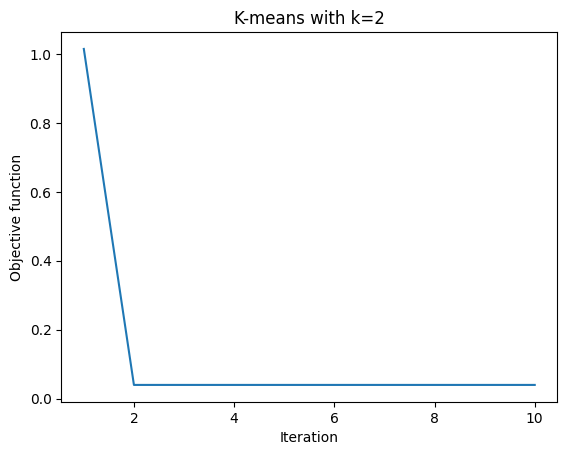

In [143]:
def k_means(X, k, max_iterations=10):
    # Initialize centroids randomly
    centroids = X[np.random.choice(X.shape[0], k, replace=True), :]

    # Initialize arrays to store assignments and objective function
    assignments = np.zeros(X.shape[0])
    obj_function = np.zeros(max_iterations)

    # Run k-means algorithm for specified number of iterations
    for i in range(max_iterations):
        # Assign each data point to the closest centroid
        for j in range(X.shape[0]):
            distances = np.sum((X[j, :] - centroids)**2, axis=1)
            assignments[j] = np.argmin(distances)

        # Update the centroids based on the new assignments
        for j in range(k):
            mask = (assignments == j)
            if np.sum(mask) > 0:
                centroids[j, :] = np.mean(X[mask, :], axis=0)

        # Calculate the objective function and store it
        obj_function[i] = np.sum((X - centroids[assignments.astype(int), :])**2)

        # Print the objective function at each iteration
        print("Iteration", i+1, "Objective function:", obj_function[i])

    # Return the final assignments and centroids
    return assignments, centroids, obj_function

# Run k-means algorithm with k=2
assignments, centroids, obj_function = k_means(SpectralEmbeddings, 2)

plt.plot(np.arange(1, len(obj_function)+1), obj_function)
plt.xlabel('Iteration')
plt.ylabel('Objective function')
plt.title('K-means with k=2')
plt.show()

## Part 5 : Scatterplot ##

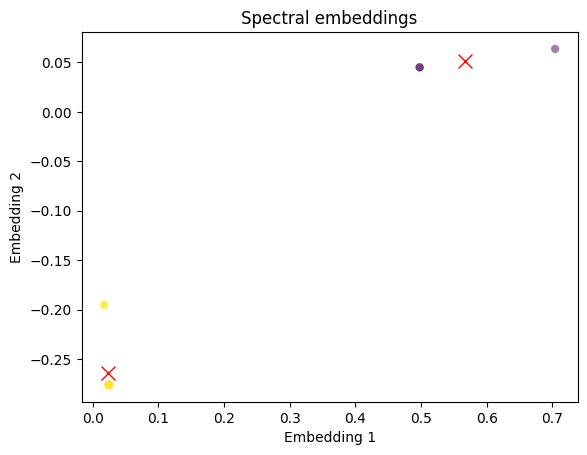

In [144]:
plt.scatter(SpectralEmbeddings[:, 0], SpectralEmbeddings[:, 1], c=assignments, cmap='viridis', alpha=0.5, edgecolors='none')

# Create a scatterplot of the k-means clusters
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=1, color='r')

# Set the axis labels and title
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.title('Spectral embeddings')

# Show the plot
plt.show()

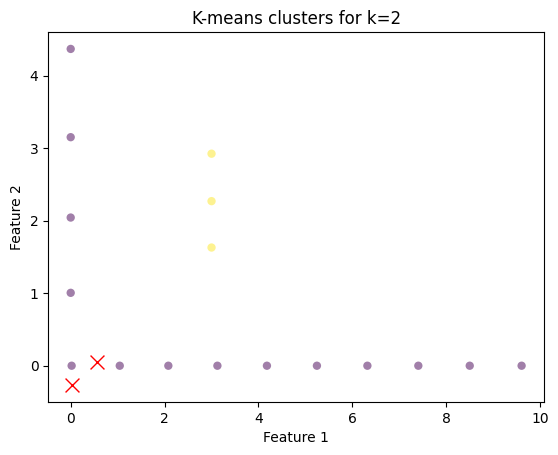

In [140]:
plt.scatter(newX[:, 0], newX[:, 1], c=assignments, cmap='viridis', alpha=0.5, edgecolors='none')

# Create a scatterplot of the k-means clusters
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=1, color='r')

# Set the axis labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means clusters for k=2')

# Show the plot
plt.show()